<a href="https://colab.research.google.com/github/boredanon/machine-learning2023-2/blob/main/proyecto_ML_Jos%C3%A9_del_Solar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Obtaining the Data


Install gspread to obtain the data directly from the google spreadsheet.

Only run this block if:


1) Running on colab


2) Running locally while not having gspread installed in your system

In [16]:
!pip install --upgrade -q gspread

Loading the data from the google spreadsheet.
Do not worry it won't delete anything from your google drive, but the credentials are needed. 👀

In [2]:
import gspread
import pandas as pd
from google.colab import auth
from google.auth import default

# Google mumbo jumbo magic stuff.
auth.authenticate_user()
creds, _ = default()

gc = gspread.authorize(creds)
sh = gc.open_by_url("https://docs.google.com/spreadsheets/d/1cJZIUTPoYliSej8ZQumPdrvWjcZeRyuEqyC4JyXpx-8/edit#gid=1570725307")
worksheet_A = sh.worksheet("A")
worksheet_B = sh.worksheet("B") #There are two worksheets.

#We have to skip the header in the second worksheet.
rows_B = worksheet_B.get_all_values()[1:]

#93 instances
rows = worksheet_A.get_all_values() + rows_B

#Skipping.
df = pd.DataFrame(rows[1:], columns = rows[0])

X = df.drop(columns=['Y'])
y = df['Y']

X = X.astype(float)
y = y.astype(float)


Check if it loaded correctly, it should be 480 columns and 93 entries for X.
93 entries and 1 column for y.

In [41]:
print(X.info(), "\n")
print(y.info())

print(X.describe())
print(y.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Columns: 480 entries, X1 to X480
dtypes: float64(480)
memory usage: 348.9 KB
None 

<class 'pandas.core.series.Series'>
RangeIndex: 93 entries, 0 to 92
Series name: Y
Non-Null Count  Dtype  
--------------  -----  
93 non-null     float64
dtypes: float64(1)
memory usage: 872.0 bytes
None
               X1          X2          X3          X4          X5          X6  \
count   93.000000   93.000000   93.000000   93.000000   93.000000   93.000000   
mean   921.198065  922.966667  921.956774  921.920108  924.829462  923.234946   
std     21.580701   23.203403   23.120603   22.511511   21.168588   22.694371   
min    898.170000  898.200000  897.320000  897.560000  901.710000  898.870000   
25%    901.530000  901.860000  900.910000  901.410000  905.570000  902.510000   
50%    904.250000  904.510000  903.540000  904.280000  908.230000  905.360000   
75%    943.910000  947.530000  946.310000  945.570000  947.030000  947.190

## Preprocessing of the data

In [5]:
print(df.isnull().sum())

Y       0
X1      0
X2      0
X3      0
X4      0
       ..
X476    0
X477    0
X478    0
X479    0
X480    0
Length: 481, dtype: int64


In [302]:
from scipy.stats import zscore
from sklearn.model_selection import train_test_split

X_zscore = zscore(X)
X_train, X_test, y_train, y_test = train_test_split(X_zscore, y, test_size=0.2)

print(X_zscore.info(), "\n")
print(X_zscore.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Columns: 480 entries, X1 to X480
dtypes: float64(480)
memory usage: 348.9 KB
None 

                 X1            X2            X3            X4            X5  \
count  9.300000e+01  9.300000e+01  9.300000e+01  9.300000e+01  9.300000e+01   
mean   8.261014e-15  3.538388e-15  3.096687e-15 -3.232778e-15  8.745692e-15   
std    1.005420e+00  1.005420e+00  1.005420e+00  1.005420e+00  1.005420e+00   
min   -1.072851e+00 -1.073157e+00 -1.071352e+00 -1.087983e+00 -1.098079e+00   
25%   -9.163126e-01 -9.145670e-01 -9.152378e-01 -9.160324e-01 -9.147446e-01   
50%   -7.895909e-01 -7.997406e-01 -8.008699e-01 -7.878511e-01 -7.884056e-01   
75%    1.058123e+00  1.064347e+00  1.059022e+00  1.056263e+00  1.054433e+00   
max    1.252864e+00  1.241569e+00  1.250360e+00  1.240719e+00  1.245842e+00   

                 X6            X7            X8            X9           X10  \
count  9.300000e+01  9.300000e+01  9.300000e+01  9.3000

In [284]:
threshold = 4
outliers_X = (abs(X_train) > threshold).any(axis=1)

X_train_no_outliers = X_train[~outliers_X]
y_train_no_outliers = y_train[~outliers_X]

alive = round((1 - (X_train_no_outliers.shape[0]/X_train.shape[0]))*100, 2)
print(alive, "% of data points were deleted.")


4.05 % of data points were deleted.


In [278]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca.fit(X_train_no_outliers)


X_train_pca = pca.transform(X_train_no_outliers)
X_test_pca = pca.transform(X_test)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.cumsum())

[0.92606459 0.02967243 0.01008071]
[0.92606459 0.95573701 0.96581772]


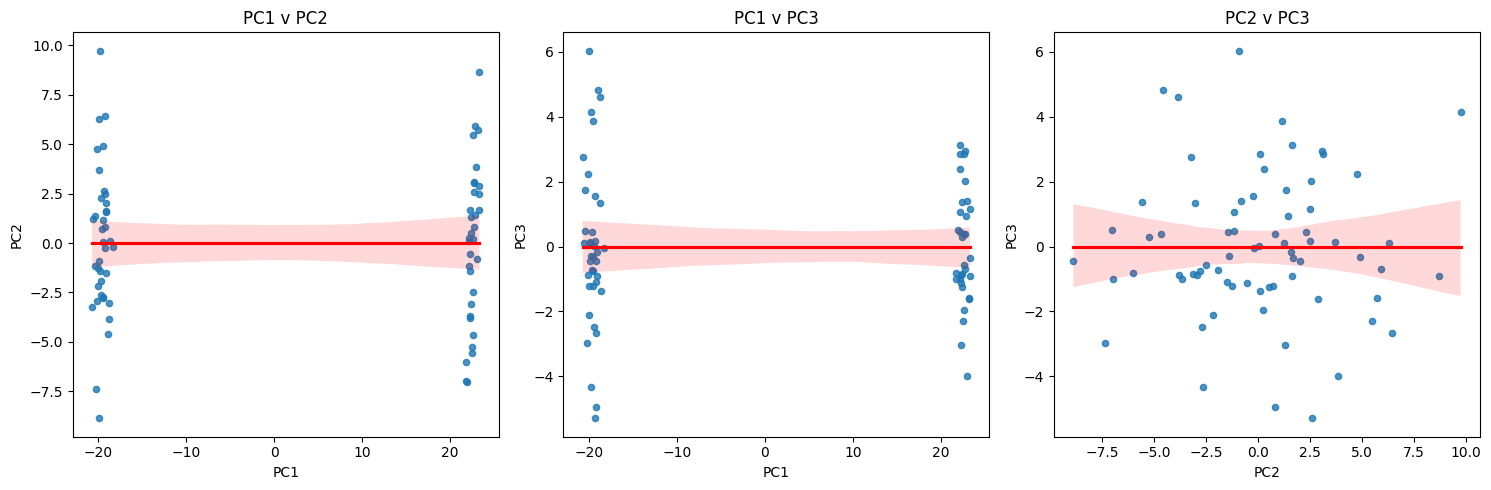

In [285]:
import seaborn as sns
import matplotlib.pyplot as plt

X_train_pca_df = pd.DataFrame(X_train_pca, columns=['PC1', 'PC2', 'PC3'])
X_train_pca_df['Y'] = y_train_no_outliers.copy()

fig, axes = plt.subplots(1, 3, figsize=(15,5))

sns.regplot(x='PC1', y='PC2', data=X_train_pca_df,scatter_kws={'s': 20}, line_kws={'color':'red'}, ax = axes[0])
sns.regplot(x='PC1', y='PC3', data=X_train_pca_df,scatter_kws={'s': 20}, line_kws={'color':'red'}, ax = axes[1])
sns.regplot(x='PC2', y='PC3', data=X_train_pca_df,scatter_kws={'s': 20}, line_kws={'color':'red'}, ax = axes[2])

axes[0].set_title('PC1 v PC2')
axes[1].set_title('PC1 v PC3')
axes[2].set_title('PC2 v PC3')

plt.tight_layout()

plt.show()

In [294]:
from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error, r2_score

svr = SVR(kernel='rbf', C=100)
svr.fit(X_train_pca, y_train_no_outliers)

SVR(C=100)

In [286]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

degree = 2
poly = make_pipeline(PolynomialFeatures(degree), LinearRegression())

poly.fit(X_train_pca, y_train_no_outliers)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

In [296]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(X_train_pca, y_train_no_outliers)


RandomForestRegressor()

In [298]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import explained_variance_score
import numpy as np

scoring_metrics = ['r2', 'neg_mean_squared_error', 'neg_root_mean_squared_error', 'explained_variance']

scores_poly = cross_validate(poly, X_train_pca, y_train_no_outliers, cv=10, scoring=scoring_metrics)
scores_svr = cross_validate(svr, X_train_pca, y_train_no_outliers, cv=10, scoring=scoring_metrics)
scores_rf = cross_validate(rf, X_train_pca, y_train_no_outliers, cv=10, scoring=scoring_metrics)

for metric in scoring_metrics:
    print(f"{metric.capitalize()} (poly): {np.mean(scores_poly[f'test_{metric}'])}, "
          f"Standard Deviation: {np.std(scores_poly[f'test_{metric}'])}")
    print(f"{metric.capitalize()} (SVR): {np.mean(scores_svr[f'test_{metric}'])}, "
          f"Standard Deviation: {np.std(scores_svr[f'test_{metric}'])}")
    print(f"{metric.capitalize()} (Random Forest): {np.mean(scores_rf[f'test_{metric}'])}, "
          f"Standard Deviation: {np.std(scores_rf[f'test_{metric}'])}\n")

R2 (poly): 0.20916899432051447, Standard Deviation: 0.5002576847902236
R2 (SVR): 0.1612139719293136, Standard Deviation: 0.46241945168552756
R2 (Random Forest): 0.1481212780111735, Standard Deviation: 0.42789161602438175

Neg_mean_squared_error (poly): -2.115400484264728, Standard Deviation: 1.4407481569892684
Neg_mean_squared_error (SVR): -2.2479393996987906, Standard Deviation: 1.2978957397961852
Neg_mean_squared_error (Random Forest): -2.341721043892858, Standard Deviation: 1.3221176075830372

Neg_root_mean_squared_error (poly): -1.369328289886482, Standard Deviation: 0.4902453658947634
Neg_root_mean_squared_error (SVR): -1.4330936330891415, Standard Deviation: 0.4406609110167996
Neg_root_mean_squared_error (Random Forest): -1.4632363686153644, Standard Deviation: 0.44795130701246927

Explained_variance (poly): 0.39315302329748325, Standard Deviation: 0.3761354709616002
Explained_variance (SVR): 0.35142034853713955, Standard Deviation: 0.3355731868956609
Explained_variance (Random F

R2 Score (SVR): -0.21146106243085505
Mean Squared Error Score (SVR): 2.5899312608993035
Root Mean Squared Error Score (SVR): 1.6093263376019493

R2 Score (Polynomial Regression): 0.04528132556514319
Mean Squared Error (Polynomial Regression): 2.041052590928244
Root Mean Squared Error (Polynomial Regression): 1.4286541187174187

R2 Score (Random Forest): 0.04528132556514319
Mean Squared Error (Random Forest): 2.041052590928244
Root Mean Squared Error (Random Forest): 1.4286541187174187



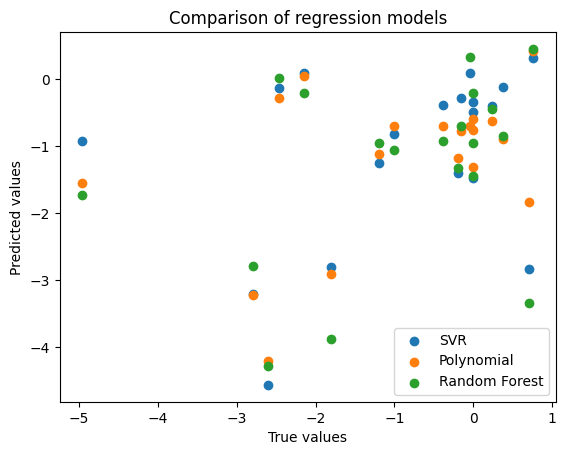

In [300]:
y_pred = svr.predict(X_test_pca)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)


print(f'R2 Score (SVR): {r2}')
print(f'Mean Squared Error Score (SVR): {mse}')
print(f'Root Mean Squared Error Score (SVR): {rmse}\n')



y_pred_poly = poly.predict(X_test_pca)

r2_poly = r2_score(y_test, y_pred_poly)
mse_poly = mean_squared_error(y_test, y_pred_poly)
rmse_poly = mean_squared_error(y_test, y_pred_poly, squared=False)
print(f'R2 Score (Polynomial Regression): {r2_poly}')
print(f'Mean Squared Error (Polynomial Regression): {mse_poly}')
print(f'Root Mean Squared Error (Polynomial Regression): {rmse_poly}\n')


y_pred_rf = rf.predict(X_test_pca)

r2_rf = r2_score(y_test, y_pred_poly)
mse_rf = mean_squared_error(y_test, y_pred_poly)
rmse_rf = mean_squared_error(y_test, y_pred_poly, squared=False)
print(f'R2 Score (Random Forest): {r2_rf}')
print(f'Mean Squared Error (Random Forest): {mse_rf}')
print(f'Root Mean Squared Error (Random Forest): {rmse_rf}\n')



#plt.scatter(X_test, y_test, label = 'True values', color='blue')
plt.scatter(y_test, y_pred, label = "SVR")
plt.scatter(y_test, y_pred_poly, label = "Polynomial")
plt.scatter(y_test, y_pred_rf, label = "Random Forest")
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title("Comparison of regression models")
plt.legend(loc = 'lower right')
plt.show()